Recreating Bansal et. al. (2000) examples: https://aiche.onlinelibrary.wiley.com/doi/epdf/10.1002/aic.690460212

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import scipy.ndimage
from matplotlib.patches import Patch
from fractions import Fraction

In [2]:
def plot_chi_function(coeff_array, var_bounds=None, resolution=400):
    """
    Plot regions where each linear inequality dominates others.

    Parameters:
        coeff_matrix (np.ndarray): m x (n+1) matrix, where each row is [a1, a2, ..., an, b]
                                   representing the inequality: a1*x1 + a2*x2 + ... + an*xn +b <= 0
        var_bounds (list of tuples): [(x1_min, x1_max), (x2_min, x2_max)] bounds for each variable.
                                     Must be length 2 for 2D visualization.
        resolution (int): Grid resolution per axis
    """
    m, cols = coeff_array.shape
    n = cols - 1
    assert n == 2, "Currently supports only 2D (x1, x2) visualizations."

    # Handle bounds per variable
    var_bounds = var_bounds if var_bounds else [(-10, 10), (-10, 10)]
    assert len(var_bounds) == 2, "var_bounds must have bounds for exactly 2 variables."

    (x_min, x_max), (y_min, y_max) = var_bounds
    x_vals = np.linspace(x_min, x_max, resolution)
    y_vals = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Compute all inequality lhs - rhs = a1*x1 + a2*x2 + b
    lhs_values = []
    for i in range(m):
        a1, a2, b = coeff_array[i]
        lhs = a1 * X + a2 * Y + b
        lhs_values.append(lhs)

    lhs_values = np.array(lhs_values)  # shape: (m, res, res)

    # Determine which inequality dominates at each (x, y)
    dominant_region = np.argmax(lhs_values, axis=0)  # shape: (res, res)

    # Generate distinct random colors
    color_names = list(mcolors.TABLEAU_COLORS) + list(mcolors.CSS4_COLORS)
    random.shuffle(color_names)
    chosen_colors = color_names[:m]

    # Plot regions
    # plt.figure(figsize=(8, 6))
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contourf(X, Y, dominant_region, levels=np.arange(-0.5, m+0.5, 1),
                 colors=chosen_colors, alpha=0.5)

    # Optional: boundary lines
    ax.contour(X, Y, dominant_region, levels=np.arange(-0.5, m), colors='black', linewidths=2)

    # Label dominant regions
    for i in range(m):
        mask = dominant_region == i
        if np.any(mask):
            cy, cx = scipy.ndimage.center_of_mass(mask)
            if not np.isnan(cx) and not np.isnan(cy):
                x_c = x_vals[int(round(cx))]
                y_c = y_vals[int(round(cy))]
                a, b, c = [Fraction(val).limit_denominator(500) for val in coeff_array[i]]
                ax.text(x_c, y_c, f"$\chi^{i+1}$ = {a}*d1 + {b}*d2 + {c}", fontsize=9,
                        ha='center', va='center',
                        bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

    # Legend
    for i in range(m):
        ax.plot([], [], color=chosen_colors[i], label=f'Inequality {i+1}')
    ax.legend()

    ax.set_title('Parametric Flexibility Test Solutions in d-space')
    ax.set_xlabel('d1')
    ax.set_ylabel('d2')
    plt.grid(True)
    plt.show()


In [3]:
# Each row: [a1, a2, b] â†’ a1*x + a2*y + b <= 0
A = np.array([
    [0.5, -1, 1/6],
    [-0.5, 0.5, 1]
])

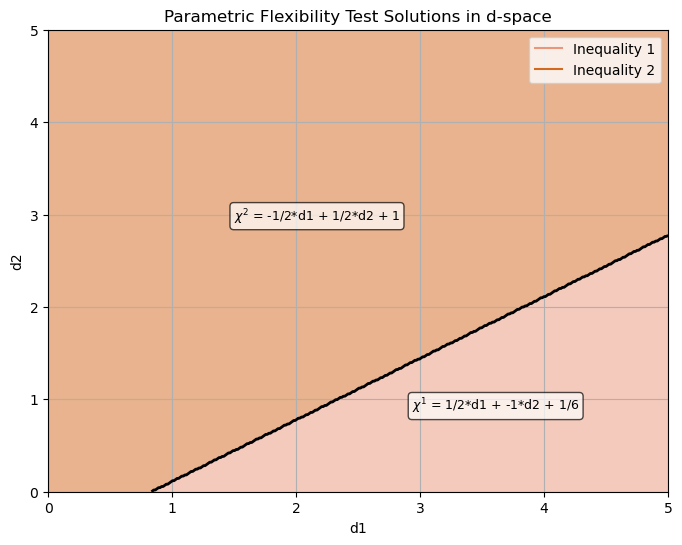

In [4]:
plot_chi_function(A, var_bounds=[(0,5), (0,5)])

In [85]:
def plot_feasible_region(coeff_array, var_bounds=None, resolution=400):
    """
    Plot:
    - Dominant regions where each expression is minimal.
    - Feasibility regions where each expression <= 0.
    - White contour lines separating feasible and infeasible regions.
    """
    m, n_plus_1 = coeff_array.shape
    n = n_plus_1 - 1
    assert n == 2, "Only 2D input is supported."

    # Set variable bounds
    var_bounds = var_bounds or [(-10, 10), (-10, 10)]
    (x_min, x_max), (y_min, y_max) = var_bounds
    x_vals = np.linspace(x_min, x_max, resolution)
    y_vals = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Evaluate each expression: a1*X + a2*Y + b
    lhs_values = np.array([
        row[0] * X + row[1] * Y + row[2] for row in coeff_array
    ])  # shape: (m, res, res)

    dominant_region = np.argmax(lhs_values, axis=0)

    # Color selection
    color_names = list(mcolors.TABLEAU_COLORS) + list(mcolors.CSS4_COLORS)
    random.shuffle(color_names)
    dom_colors = color_names[:m]
    feas_colors = color_names[m:m*2]

    # Plot dominant regions
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contourf(X, Y, dominant_region, levels=np.arange(-0.5, m + 0.5),
                colors=dom_colors, alpha=0.5)
    ax.contour(X, Y, dominant_region, levels=np.arange(-0.5, m), colors='black', linewidths=1)

    # Overlay feasibility regions and white boundaries
    for i in range(m):
        feas_mask = lhs_values[i] >= 0

        # Feasibility overlay
        ax.contourf(X, Y, feas_mask, levels=[0.5, 1], hatches=['//'],
                    colors=[feas_colors[i]], alpha=0.3)

        # White line for the boundary where expression = 0
        ax.contour(X, Y, lhs_values[i], levels=[0], colors='white', linewidths=2)

    # Label dominant regions
    for i in range(m):
        mask = dominant_region == i
        if np.any(mask):
            cy, cx = scipy.ndimage.center_of_mass(mask)
            if not np.isnan(cx) and not np.isnan(cy):
                x_c = x_vals[int(round(cx))]
                y_c = y_vals[int(round(cy))]
                ax.text(x_c, y_c, f"Expression {i+1}", fontsize=9,
                        ha='center', va='center',
                        bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

    # Create legend
    legend_elements = []
    for i in range(m):
        legend_elements.append(Patch(facecolor=dom_colors[i], label=f'Maximum: Expr {i+1}'))
        legend_elements.append(Patch(facecolor=feas_colors[i], hatch='//', label=f'Infeasible: Expression {i+1}', alpha=0.3))
    ax.legend(handles=legend_elements, loc='upper right')

    ax.set_xlabel("d1")
    ax.set_ylabel("d2")
    ax.set_title("Feasible region in d-space")
    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [86]:
A = np.array([
    [0.5, -1, 1/6],
    [-0.5, 0.5, 1]
])

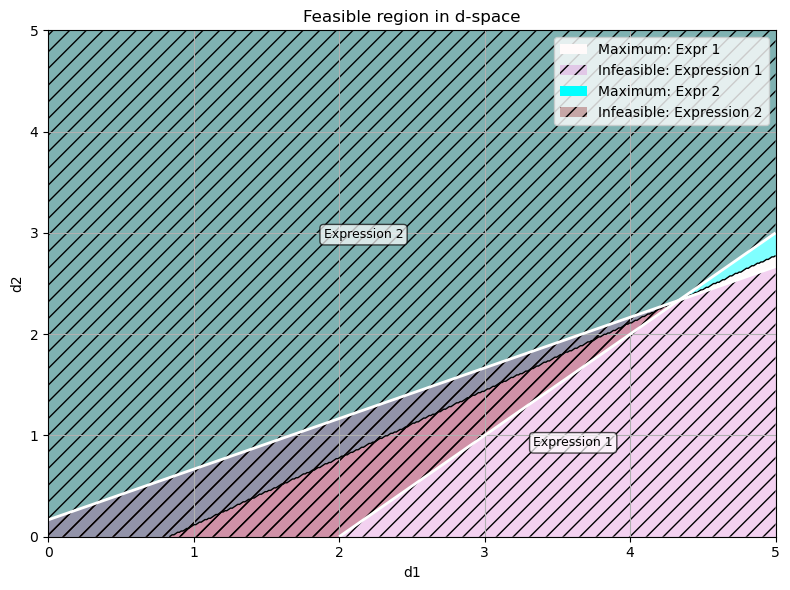

In [87]:
plot_feasible_region(A, var_bounds=[(0,5), (0,5)])

In [8]:
def plot_flexibility_index(coeff_array, var_bounds=None, resolution=400):
    """
    Plot:
    - Dominant regions where each expression is minimal.
    - Feasibility regions where each expression <= 0.
    - White contour lines separating feasible and infeasible regions.
    """
    m, n_plus_1 = coeff_array.shape
    n = n_plus_1 - 1
    assert n == 2, "Only 2D input is supported."

    # Set variable bounds
    var_bounds = var_bounds or [(0, 10), (0, 10)]
    (x_min, x_max), (y_min, y_max) = var_bounds
    x_vals = np.linspace(x_min, x_max, resolution)
    y_vals = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Evaluate each expression: a1*X + a2*Y + b
    lhs_values = np.array([
        row[0] * X + row[1] * Y + row[2] for row in coeff_array
    ])  # shape: (m, res, res)

    dominant_region = np.argmin(lhs_values, axis=0)

    # Color selection
    color_names = list(mcolors.TABLEAU_COLORS) + list(mcolors.CSS4_COLORS)
    random.shuffle(color_names)
    dom_colors = color_names[:m]
    feas_colors = color_names[m:m*2]

    # Plot dominant regions
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contourf(X, Y, dominant_region, levels=np.arange(-0.5, m + 0.5),
                colors=dom_colors, alpha=0.5, zorder=1)
    ax.contour(X, Y, dominant_region, levels=np.arange(-0.5, m), colors='black', linewidths=1, zorder=1)

    # Overlay feasibility regions and white boundaries
    for i in range(m):
        feas_mask = lhs_values[i] <= 0

        # Feasibility overlay
        ax.contourf(X, Y, feas_mask, levels=[0.5, 1], hatches=['////'],
                    colors=[feas_colors[i], 'none'], alpha=0.3, zorder=10)

        # White line for the boundary where expression = 0
        ax.contour(X, Y, lhs_values[i], levels=[0], colors='white', linewidths=2, zorder=10)

    # Label dominant regions
    for i in range(m):
        mask = dominant_region == i
        if np.any(mask):
            cy, cx = scipy.ndimage.center_of_mass(mask)
            if not np.isnan(cx) and not np.isnan(cy):
                x_c = x_vals[int(round(cx))]
                y_c = y_vals[int(round(cy))]
                a, b, c = [Fraction(val).limit_denominator(500) for val in coeff_array[i]]
                ax.text(x_c, y_c, f"$F^{i+1}$ = {a}*d1 + {b}*d2 + {c}", fontsize=9,
                        ha='center', va='center',
                        bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

    # Create legend
    legend_elements = []
    for i in range(m):
        legend_elements.append(Patch(facecolor=dom_colors[i], label=f'Minimum: Expr {i+1}'))
        legend_elements.append(Patch(facecolor=feas_colors[i], hatch='////', label=f'Infeasible: Expression {i+1}', alpha=0.3))
    ax.legend(handles=legend_elements, loc='upper right', framealpha=0.8)

    ax.set_xlabel("d1")
    ax.set_ylabel("d2")
    ax.set_title("Parametric Flexibility Index Solutions in d-space")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
A = np.array([
    [-3/11, 6/11, 10/11],
    [3/16, -3/16, 10/16],
])

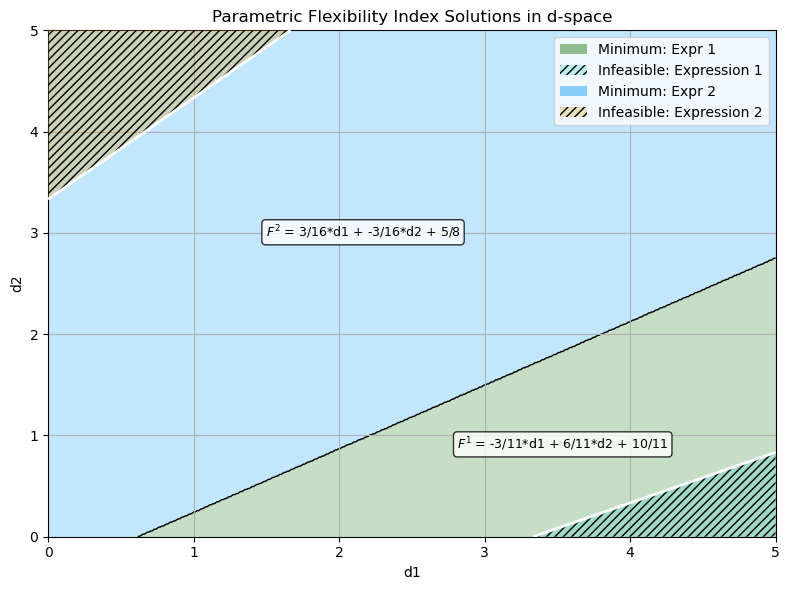

In [78]:
plot_flexibility_index(A, var_bounds=[(0, 5), (0, 5)], resolution=500)

In [11]:
# A = np.array([
#     [1, 2, 5],
#     [3, -1, 4],
#     [-2, 1, -3],
#     [2, -3, 1]
# ])
# 
# plot_inequality_dominance(A, var_bounds=[(-10,10), (-10,10)])

In [12]:
# # SOMETHING IS INCORRECT HERE
# def evaluate_with_region_constraints(
#     A_main, 
#     A_regions=None, 
#     x_range=(-10, 10), 
#     y_range=(-10, 10), 
#     resolution=400
# ):
#     """
#     Parameters:
#     ----------
#     A_main : np.ndarray, shape (m, 3)
#         Rows represent inequality coefficients: a1*x + a2*y + b <= 0
#     A_regions : list of np.ndarrays, optional
#         Each element is a matrix (k_i, 3) defining the feasible region for inequality i
#     x_range : tuple of (xmin, xmax)
#     y_range : tuple of (ymin, ymax)
#     resolution : int
#         Number of points along each axis for meshgrid
#     """
#     m, n_plus_1 = A_main.shape
#     assert n_plus_1 == 3, "Only 2D case supported (x, y)"
# 
#     # Generate grid
#     x_vals = np.linspace(*x_range, resolution)
#     y_vals = np.linspace(*y_range, resolution)
#     X, Y = np.meshgrid(x_vals, y_vals)
# 
#     dominant_vals = np.full(X.shape, np.nan)
#     dominant_idx = np.full(X.shape, -1)
# 
#     for i in range(m):
#         a1, a2, b = A_main[i]
# 
#         # Default: all points are feasible
#         feasible_mask = np.ones(X.shape, dtype=bool)
# 
#         if A_regions is not None and A_regions[i] is not None:
#             region_constraints = A_regions[i]
#             for constraint in region_constraints:
#                 c1, c2, d = constraint
#                 lhs = c1 * X + c2 * Y + d
#                 feasible_mask &= (lhs <= 0)
# 
#         # Evaluate the main inequality on feasible region
#         lhs_main = a1 * X + a2 * Y + b
#         masked_lhs = np.where(feasible_mask, lhs_main, np.inf)
# 
#         update_mask = (masked_lhs < dominant_vals) | np.isnan(dominant_vals)
#         dominant_vals = np.where(update_mask, masked_lhs, dominant_vals)
#         dominant_idx = np.where(update_mask, i, dominant_idx)
# 
#     # Plotting
#     colors = random.sample(list(mcolors.TABLEAU_COLORS.values()), m)
#     plt.figure(figsize=(8, 6))
#     plt.contourf(X, Y, dominant_idx, levels=np.arange(-0.5, m+0.5), colors=colors, alpha=0.5)
#     plt.contour(X, Y, dominant_idx, levels=np.arange(-0.5, m), colors='black', linewidths=0.5)
# 
#     # Legend
#     for i in range(m):
#         plt.plot([], [], color=colors[i], label=f'Inequality {i+1}')
#     plt.legend()
#     plt.xlabel("x")
#     plt.ylabel("y")
#     plt.title("Dominant Inequality per Region")
#     plt.grid(True)
#     plt.show()


In [13]:
# A_main = np.array([
#     [0.5, -1, 1/6],
#     [-0.5, 0.5, 1]
# ])
# 
# A_regions = [
#     np.array([[-2, 3, -1], [-1, 0, 0], [1, 0, -5]]),
#     np.array([[2, -3, -7], [-1, 0, 0], [0, 1, -5]])
# ]

In [14]:
# evaluate_with_region_constraints(A_main=A_main, A_regions=A_regions, x_range=(0,5), y_range=(0,5))

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

def evaluate_with_region_constraints2(
    A_main, 
    A_regions=None, 
    x_range=(-10, 10), 
    y_range=(-10, 10), 
    resolution=400
):
    m, n_plus_1 = A_main.shape
    assert n_plus_1 == 3, "Only 2D case supported (x, y)"

    # Generate grid
    x_vals = np.linspace(*x_range, resolution)
    y_vals = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Initialize with +inf so we can minimize over it
    dominant_vals = np.full(X.shape, np.inf)
    dominant_idx = np.full(X.shape, -1)

    for i in range(m):
        a1, a2, b = A_main[i]

        # Default: all points are feasible
        feasible_mask = np.ones(X.shape, dtype=bool)

        if A_regions is not None and A_regions[i] is not None and len(A_regions[i]) > 0:
            region_constraints = A_regions[i]
            for constraint in region_constraints:
                c1, c2, d = constraint
                lhs = c1 * X + c2 * Y + d
                feasible_mask &= (lhs <= 0)

        # Evaluate the inequality
        lhs_main = a1 * X + a2 * Y + b

        # Set infeasible points to +inf
        masked_lhs = np.where(feasible_mask, lhs_main, np.inf)

        # Update dominant inequality: take the one with min value
        update_mask = masked_lhs < dominant_vals
        dominant_vals = np.where(update_mask, masked_lhs, dominant_vals)
        dominant_idx = np.where(update_mask, i, dominant_idx)

    # Plotting
    colors = random.sample(list(mcolors.TABLEAU_COLORS.values()), m)
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, dominant_idx, levels=np.arange(-0.5, m+0.5), colors=colors, alpha=0.5)
    plt.contour(X, Y, dominant_idx, levels=np.arange(-0.5, m), colors='black', linewidths=0.5)

    # Legend
    for i in range(m):
        plt.plot([], [], color=colors[i], label=f'Inequality {i+1}')
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Dominant Inequality per Region")
    plt.grid(True)
    plt.show()

In [75]:
A_main = np.array([
    [0.5, -1, 1/6],
    [-0.5, 0.5, 1]
])

A_regions = [
    np.array([[-2, 3, -1], [-1, 0, 0], [1, 0, -5], [-2, 3, 5/3]]),
    np.array([[2, -3, -7], [-1, 0, 0], [0, 1, -5], [2, -3, -5/3] ])
]

# A_regions = [
#     np.array([[-2, 3, 5/3], [-2, 3, 1]]),
#     np.array([[2, -3, -5/3], [2, -3, -7]])
# ]

# A_regions = [
#     np.array([[-2, 3, 1]]),
#     np.array([[2, -3, -7]])
# ]

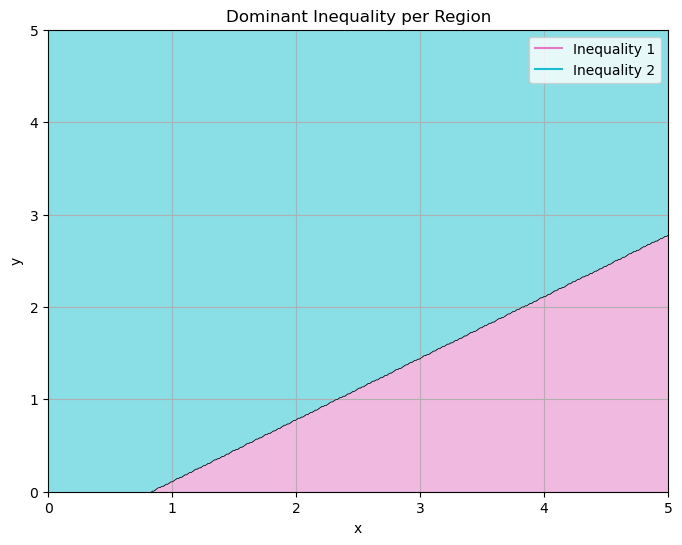

In [76]:
evaluate_with_region_constraints2(A_main=A_main, A_regions=A_regions, x_range=(0,5), y_range=(0,5))